In [1]:
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
from sklearn.manifold import Isomap

from made.can import CAN
from made.utils import simulate_many_with_initial_states
from made.visuals import clean_axes
from made import manifolds
from made.manifolds import PADS

# Set parameters

In [2]:
TOPOLOGY = 'MobiusBand'  # change the manifold topology
N_SAMPLES = 50  # increase this for more dense sampling, especially for 1D manifolds
N_SIMULATION_STEPS = 25



PAD = PADS[TOPOLOGY]

if TOPOLOGY in ['Line', 'Ring'] and N_SAMPLES < 200:
    logger.warning(f"For {TOPOLOGY} manifold, N_SAMPLES should be at least 200 for good sampling")

if TOPOLOGY == 'Sphere' and N_SAMPLES < 1000:
    logger.warning(f"For {TOPOLOGY} manifold, N_SAMPLES should be at least 1000 for good sampling")

if TOPOLOGY in ['Plane', 'Torus', 'Cylinder', 'MobiusBand'] and N_SAMPLES > 100:
    logger.warning(f"For {TOPOLOGY} manifold, N_SAMPLES should be <100 since we'll actually take the square of this number of samples")


## Simulations
Create a CAN with the desired topology, sample some points over the parameter sspace and run simulations with 
activity bumps at these points. We run multiple simulations in parallel to speed up the process. 


2025-01-21 12:15:20.462 | INFO     | __main__:<module>:8 - Samples shape: (834, 2) - values range from -1.8 to 6.157521601035995


CAN(spacing=0.2, N neurons=640)


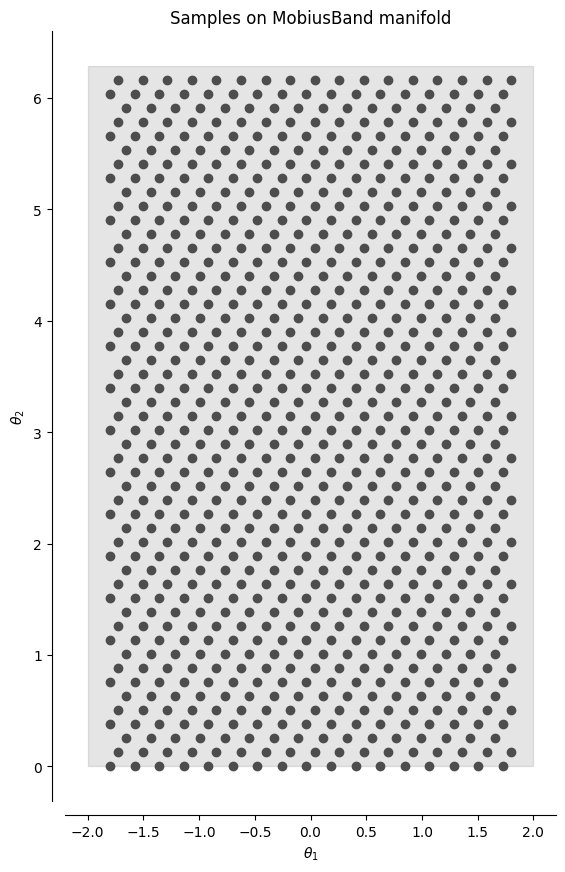

In [3]:
can = CAN.default(topology=TOPOLOGY)
print(can)

samples = can.manifold.parameter_space.sample(N_SAMPLES, pads=PAD)
if can.manifold.dim > 1:
    samples = samples[::3, :,]

logger.info(f'Samples shape: {samples.shape} - values range from {samples.min()} to {samples.max()}')

f, ax = plt.subplots(1, 1, figsize=(10, 10))
can.manifold.visualize(ax)
if can.manifold.dim == 1:
    ax.scatter(samples[:, 0], np.zeros_like(samples[:, 0]), color=[.3, .3, .3])
elif isinstance(can.manifold, manifolds.Sphere):
    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111, projection='3d')
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], color=[.3, .3, .3])
else:
    ax.scatter(samples[:, 0], samples[:, 1], color=[.3, .3, .3])

clean_axes(ax, title=f"Samples on {TOPOLOGY} manifold")
plt.show()



In [4]:
final_states = simulate_many_with_initial_states(can, samples, N_SIMULATION_STEPS)
logger.info(f'Matrix of final states has shape: {final_states.shape}')


Output()

2025-01-21 12:15:26.505 | INFO     | __main__:<module>:2 - Matrix of final states has shape: (834, 640)


## Visualization
First, we take each final state and plot the position of the maximum activity in the lattice (the bump position).
This way we can see what the distribution of bumps looks like in the parameter space. 


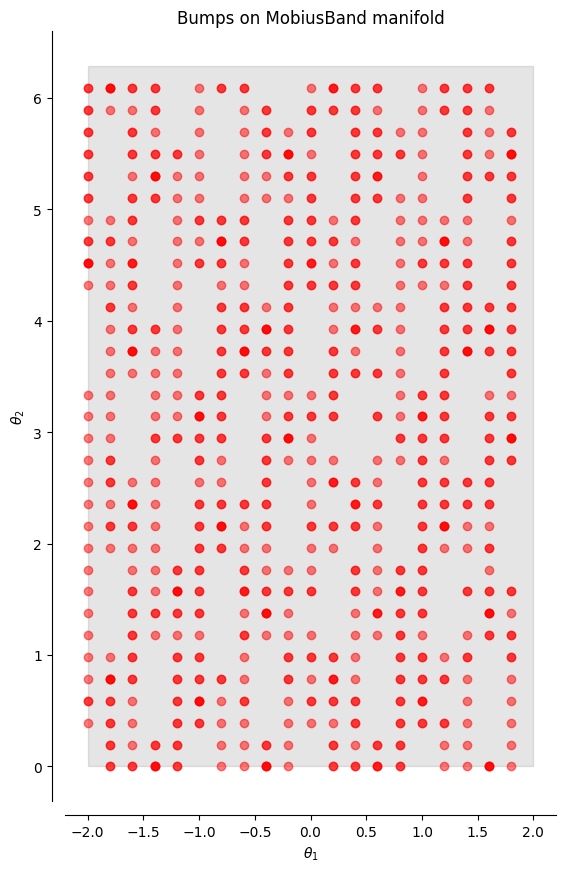

In [5]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

can.manifold.visualize(ax)

if can.manifold.dim > 1:
    nx, ny = can.nx(0), can.nx(1)
else:
    nx, ny = can.nx(0), 1

if not isinstance(can.manifold, manifolds.Sphere):
    for idx in range(0, len(final_states), 1):
        state = final_states[idx].reshape(nx, ny)
        if can.manifold.dim > 1:
            # get coords of max value
            x, y = np.unravel_index(np.argmax(state), state.shape)
            x = can.idx2coord(x, 0)
            y = can.idx2coord(y, 1)
        else:
            x = can.idx2coord(np.argmax(state), dim=0)
            y = 0
        ax.scatter(x, y, color='red', alpha=.5)
else:
    print("This plot is not implemented for the sphere")


clean_axes(ax, title=f"Bumps on {TOPOLOGY} manifold")
plt.show()



Then, we use PCA and Isomap to reduce the dimensionality of the final states to 3 so taht we can visualize them. This shows us the topology of the activity manifold in state space. 

Play around with `view_init` to find a perspective that shows the manifold topology.

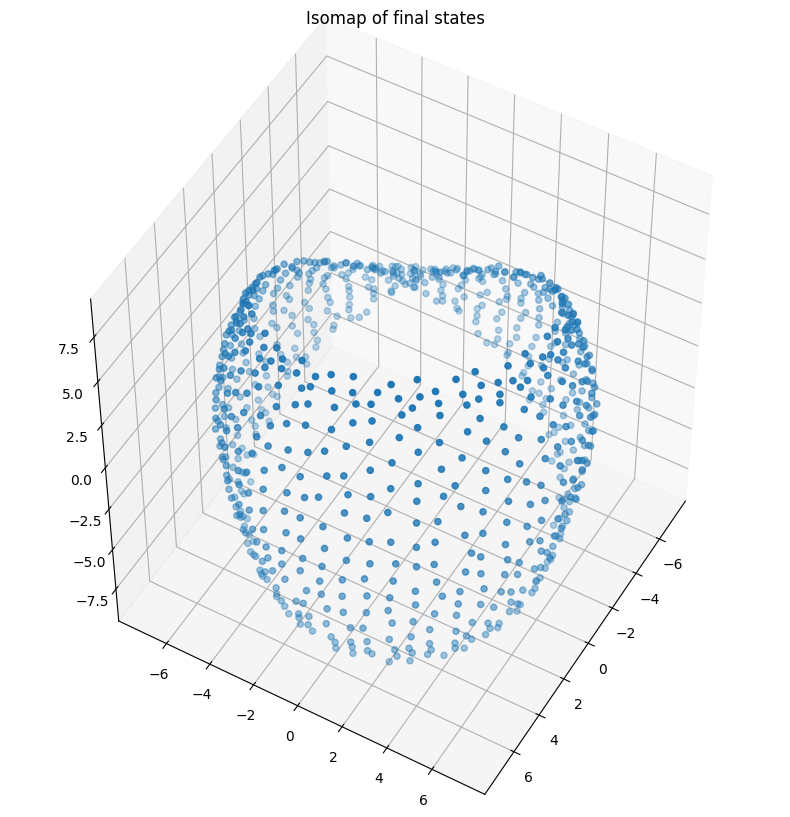

In [6]:
# Isomap to reduce dimensionality
isomap = Isomap(n_components=3, n_neighbors=21)
final_states_isomap = isomap.fit_transform(final_states)

# visualize as 3D scatter
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(111, projection='3d')
ax.scatter(final_states_isomap[:, 0], final_states_isomap[:, 1], final_states_isomap[:, 2])
ax.set_title('Isomap of final states')
ax.set_aspect('equal')

ax.view_init(elev=50, azim=30)
plt.show()

